<a id='0'></a>
# <p style="background-color:blue; font-family:newtimeroman; font-size:100%; text-align:center; border-radius: 15px 50px; color:white;">Please upvote the notebook as well if you find it useful and forking the notebook🎯 </p>

<a id='0'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:250%; text-align:center; border-radius: 15px 50px;">Coleridge Initiative🖋📝 - EDA📚 & Baseline Model🎯 </p>

# <p style="font-family:newtimeroman; text-align:center; fontsize:150%">Coleridge Initiative - Show US the Data<br>Discover how data is used for the public good</p>
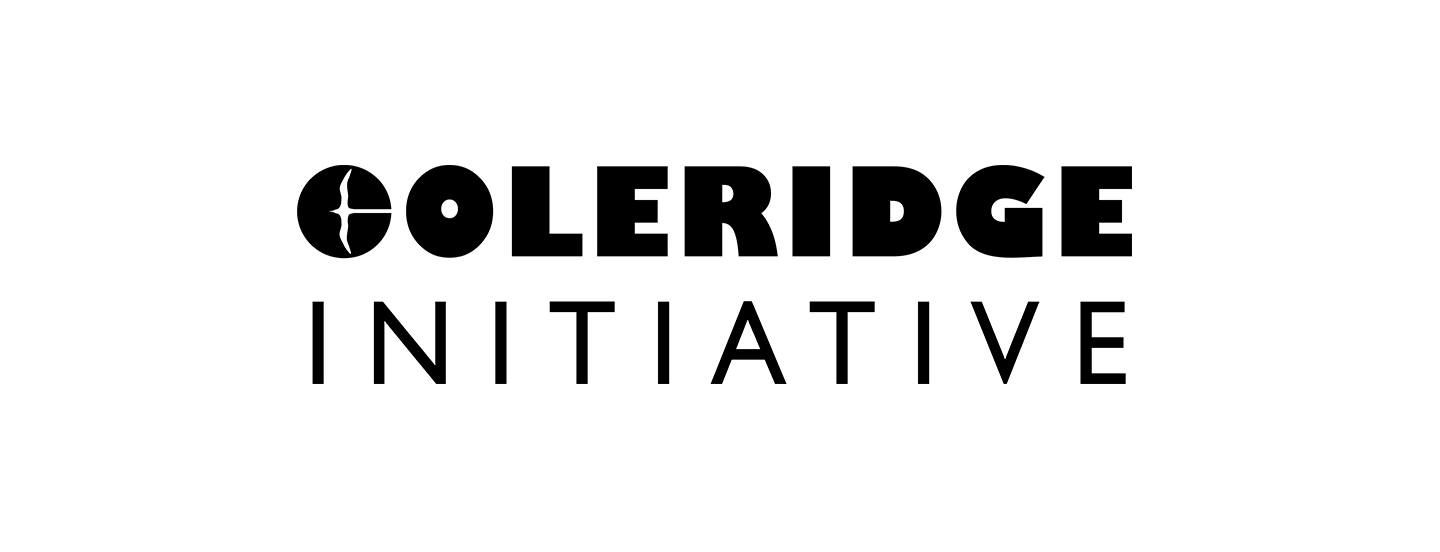

## Hey There! 🙌🏻🙋🏻‍♂️
In this notebook basically we have to predict text for some strings by using nlp techniques.
*** 
>The objective of the competition is to identify the mention of datasets within scientific publications.

This competition challenges data scientists to show how publicly funded data are used to serve science and society. Evidence through data is critical if government is to address the many threats facing society, including; pandemics, climate change, Alzheimer’s disease, child hunger, increasing food production, maintaining biodiversity, and addressing many other challenges. Yet much of the information about data necessary to inform evidence and science is locked inside publications.

The Coleridge Initiative is a not-for-profit organization originally established at New York University. It was set up in order to inform the decision-making of the Commission on Evidence-based Policymaking and has since worked with dozens of government agencies at the federal, state, and local levels to ensure that data are more effectively used for public decision-making.

It achieves this goal by working with the agencies to create value for the taxpayer from the careful use of data by building new technologies to enable secure access to and sharing of confidential microdata and by training agency staff to acquire modern data skills.

### Special thanks to helper notebooks 🙏🏻:- 
1. [Tabular Data Preparation, Basic EDA and Baseline](https://www.kaggle.com/manabendrarout/tabular-data-preparation-basic-eda-and-baseline)
2. [Coleridge - Data Loading, EDA & Simple Submission](https://www.kaggle.com/poornap/coleridge-data-loading-eda-simple-submission)
3. [Coleridge Initiative - EDA + Naïve Submission 📚](https://www.kaggle.com/josephassaker/coleridge-initiative-eda-na-ve-submission/data)

<a id='1'></a>
# <p style="background-color:red; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 10px 25px;">Table of Content</p>
* [1. Importing necessary modules and libraries📚](#1)
* [2. Data Exploration🔍](#2)
* [3. Data Cleaning🔧](#3)
* [4. Data Vizualization🎨](#4)
* [5. Baseline model and Submission📝](#5)

<a id='1'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:250%; text-align:center; border-radius: 15px 50px;">1. Importing necessary modules and libraries📚</p>

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

import os
import re
import json
import glob
from collections import defaultdict
from textblob import TextBlob
from functools import partial
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

import nltk
import spacy
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])
nlp.max_length = 4000000
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS

from tqdm.autonotebook import tqdm
import string

%matplotlib inline

random.seed(123)
np.random.seed(456)

os.listdir('/kaggle/input/coleridgeinitiative-show-us-the-data/')

In [ ]:
!pip install datasets --no-index --find-links=file:///kaggle/input/coleridge-packages/packages/datasets
!pip install ../input/coleridge-packages/seqeval-1.2.2-py3-none-any.whl
!pip install ../input/coleridge-packages/tokenizers-0.10.1-cp37-cp37m-manylinux1_x86_64.whl
!pip install ../input/coleridge-packages/transformers-4.5.0.dev0-py3-none-any.whl

In [ ]:
!cp /kaggle/input/coleridge-packages/my_seqeval.py ./

We are provided with 4 main pieces of data:

* `train.csv:` The CSV file containing all the metadata of the publications, such as their title and the dataset they utilize.
* `train:` The directory containing the actual publications that are referenced in train.csvin JSON format.
* `test:` The directory containing the actual publications that will be used for testing purposes (thus, with no ground truth CSV file available).
* `sample_submission.csv:` The CSV file containing all the publications IDs in the test set, for which we'll have to populate the prediction column.

<a id='2'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">2. Data Exploration🔍</p>

In [ ]:
# reading csv files and train & test file paths
train_df = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/train.csv')
sample_sub = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/sample_submission.csv')
train_files_path = '../input/coleridgeinitiative-show-us-the-data/train'
test_files_path = '../input/coleridgeinitiative-show-us-the-data/test'

<a id='1'></a>
## <p style="text-align:center;">Data Description</p>
train.csv - labels and metadata for the training set train/test directory - the full text of the training/test set's publications in JSON format, broken into sections with section titles

* `id` - publication id - note that there are multiple rows for some training documents, indicating multiple mentioned datasets.
* `pub_title` - title of the publication (a small number of publications have the same title).
* `dataset_title` - the title of the dataset that is mentioned within the publication.
* `dataset_label` - a portion of the text that indicates the dataset.
* `cleaned_label` - the dataset_label, as passed through the clean_text function from the Evaluation page.

sample_submission.csv - a sample submission file in the correct format.
* `Id` - publication id.
* `PredictionString` - To be filled with equivalent of cleaned_label of train data.

Great! we don't have any null values.

In [ ]:
def read_append_return(filename, train_files_path=train_files_path, output='text'):
    """
    Function to read json file and then return the text data from them and append to the dataframe
    """
    json_path = os.path.join(train_files_path, (filename+'.json'))
    headings = []
    contents = []
    combined = []
    with open(json_path, 'r') as f:
        json_decode = json.load(f)
        for data in json_decode:
            headings.append(data.get('section_title'))
            contents.append(data.get('text'))
            combined.append(data.get('section_title'))
            combined.append(data.get('text'))
    
    all_headings = ' '.join(headings)
    all_contents = ' '.join(contents)
    all_data = '. '.join(combined)
    
    if output == 'text':
        return all_contents
    elif output == 'head':
        return all_headings
    else:
        return all_data

In [ ]:
%%time
tqdm.pandas()   #tqdm is used to show any code running with a progress bar. 
train_df['text'] = train_df['Id'].progress_apply(read_append_return)

In [ ]:
train_df.head()
train_df = train_df[0:2000]

We have our text appended in our train dataframe.

In [ ]:
%%time
tqdm.pandas()
sample_sub['text'] = sample_sub['Id'].progress_apply(partial(read_append_return, train_files_path=test_files_path))

Also, we have the text of for the sample_submission file

### Let's investigate where in the text the dataset is often found

In [ ]:
#text_loc = []
#section_loc = []
#sentence_loc = []
#for index, row in tqdm(train_df.iterrows()):
#    ID = row['Id']
#    text = row['text']
#    sentences = nltk.tokenize.sent_tokenize(text)
#    datasets = set([row['dataset_title'], row['dataset_label'], row['cleaned_label']])
#    json_path = os.path.join(train_files_path, (ID + '.json'))
    
    # Find relative text locations
#    for dataset in datasets:
#        t_loc = text.find(dataset)
#        if t_loc != -1:
#            text_loc.append(t_loc/len(text))

    # Find relative section locations   
#    with open(json_path, 'r') as f:
#        json_decode = json.load(f)
#        for dataset in datasets:
#            for i, data in enumerate(json_decode):
#                section = data.get('text')
#                sect_loc = section.find(dataset)
#                if sect_loc != -1:
#                    section_loc.append(sect_loc/len(section))
                    
    # Find relative sentence locations   
#    for dataset in datasets:
#        for sentence in sentences:            
#            sent_loc = sentence.find(dataset)
#            if sent_loc != -1:
#                sentence_loc.append(sent_loc/len(sentence))
                    

#bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
#text_loc = np.digitize(text_loc,bins=bins)

#plt.hist(text_loc)

In [ ]:
#plt.hist(np.digitize(section_loc,bins=bins))

In [ ]:
#plt.hist(np.digitize(sentence_loc,bins=bins))

<a id='3'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">3. Data Cleaning🔧</p>

In [ ]:
def text_cleaning(text):
    '''
    Converts all text to lower case, Removes special charecters, emojis and multiple spaces
    text - Sentence that needs to be cleaned
    '''
    text = ''.join([k for k in text if k not in string.punctuation])
    text = re.sub('r[^\w\s]', ' ', str(text).lower()).strip()
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    text = lem.lemmatize(text)
#     text = re.sub('[^A-Za-z0-9]+', ' ', str(text).lower()).strip()
#     text = re.sub("/'+/g", ' ', text)
    
    return text

In [ ]:
%%time
tqdm.pandas()
train_df['text'] = train_df['text'].progress_apply(text_cleaning)

It takes time!🙄

In [ ]:
# %%time 
# tqdm.pandas()
# sample_sub['text'] = sample_sub['text'].progress_apply(text_cleaning)

We have our data cleaned!

In [ ]:
def clean_text(txt):
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower()).strip()

In [ ]:
# %%time
# tqdm.pandas()
# train_df['text'] = train_df['text'].progress_apply(prepare_text)

<a id='5'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">5. Baseline model and Submission📝</p>

In [ ]:
temp_1 = [x.lower() for x in train_df['dataset_label'].unique()]
temp_2 = [x.lower() for x in train_df['dataset_title'].unique()]
temp_3 = [x.lower() for x in train_df['cleaned_label'].unique()]

existing_labels = set(temp_1 + temp_2 + temp_3)
id_list = []
lables_list = []
for index, row in tqdm(sample_sub.iterrows()):
    sample_text = row['text']
    row_id = row['Id']
    
    # Check if the sample text is equal to one of the train samples (and if so, use those labels)
    temp_df = train_df[train_df['text'] == text_cleaning(sample_text)]
    cleaned_labels = temp_df['cleaned_label'].to_list()
    
    # Check if any of the known labels is present in the sample text
    for known_label in existing_labels:
        if known_label in sample_text.lower():
            cleaned_labels.append(clean_text(known_label))
            
    # Clean all labels
    cleaned_labels = [clean_text(x) for x in cleaned_labels]
    cleaned_labels = set(cleaned_labels)
    lables_list.append('|'.join(cleaned_labels))
    id_list.append(row_id)

In [ ]:
#submission = pd.DataFrame()
#submission['Id'] = id_list
#submission['PredictionString'] = lables_list

In [ ]:
# pd.set_option("display.max_rows", None, "display.max_columns", None)
#submission.head()

In [ ]:
#submission.to_csv('submission.csv', index=False)

## Hurray! We are done with the submission and model. Hope you like this kernel. If so, don't forget to upvote and leave your valuable comment. Thank you😊

In [ ]:
def clean_training_text(txt):
    """
    similar to the default clean_text function but without lowercasing.
    """
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt)).strip()

def shorten_sentences(sentences):
    short_sentences = []
    for sentence in sentences:
        words = sentence.split()
        if len(words) > MAX_LENGTH:
            for p in range(0, len(words), MAX_LENGTH - OVERLAP):
                short_sentences.append(' '.join(words[p:p+MAX_LENGTH]))
        else:
            short_sentences.append(sentence)
    return short_sentences


# Make predictions using BERT

In [ ]:
PREDICT_BATCH = 64000 
MAX_LENGTH = 64 # max no. words for each sentence.
OVERLAP = 20 # if a sentence exceeds MAX_LENGTH, we split it to multiple sentences with overlapping

PRETRAINED_PATH = '../input/coleridge-bert-models/output'
TEST_INPUT_SAVE_PATH = './input_data'
TEST_NER_DATA_FILE = 'test_ner_input.json'
TRAIN_PATH = '../input/coleridge-bert-models/train_ner.json'
VAL_PATH = '../input/coleridge-bert-models/train_ner.json'

PREDICTION_SAVE_PATH = './pred'
PREDICTION_FILE = 'test_predictions.txt'

In [ ]:
sample_submission_path = '../input/coleridgeinitiative-show-us-the-data/sample_submission.csv'
sample_submission = pd.read_csv(sample_submission_path)

papers = {}
paper_test_folder = '../input/coleridgeinitiative-show-us-the-data/test'
for paper_id in sample_submission['Id']:
    with open(f'{paper_test_folder}/{paper_id}.json', 'r') as f:
        paper = json.load(f)
        papers[paper_id] = paper

In [ ]:
test_rows = [] # test data in NER format
paper_length = [] # store the number of sentences each paper has

for paper_id in sample_submission['Id']:
    # load paper
    paper = papers[paper_id]
    
    # extract sentences
    sentences = [clean_training_text(sentence) for section in paper 
                 for sentence in section['text'].split('.')
                ]
    sentences = shorten_sentences(sentences) # make sentences short
    sentences = [sentence for sentence in sentences if len(sentence) > 10] # only accept sentences with length > 10 chars
    sentences = [sentence for sentence in sentences if any(word in sentence.lower() for word in ['data', 'study'])]
        
    # collect all sentences in json
    for sentence in sentences:
        sentence_words = sentence.split()
        dummy_tags = ['O']*len(sentence_words)
        test_rows.append({'tokens' : sentence_words, 'tags' : dummy_tags})
    
    # track which sentence belongs to which data point
    paper_length.append(len(sentences))
    
print(f'total number of sentences: {len(test_rows)}')

In [ ]:
os.environ["MODEL_PATH"] = f"{PRETRAINED_PATH}"
os.environ["TRAIN_FILE"] = f"{TRAIN_PATH}"
os.environ["VALIDATION_FILE"] = f"{VAL_PATH}"
os.environ["TEST_FILE"] = f"{TEST_INPUT_SAVE_PATH}/{TEST_NER_DATA_FILE}"
os.environ["OUTPUT_DIR"] = f"{PREDICTION_SAVE_PATH}"

In [ ]:
os.makedirs(TEST_INPUT_SAVE_PATH, exist_ok=True)

In [ ]:
def bert_predict():
    !python ../input/kaggle-ner-utils/kaggle_run_ner.py \
    --model_name_or_path "$MODEL_PATH" \
    --train_file "$TRAIN_FILE" \
    --validation_file "$VALIDATION_FILE" \
    --test_file "$TEST_FILE" \
    --output_dir "$OUTPUT_DIR" \
    --report_to 'none' \
    --seed 123 \
    --do_predict

In [ ]:
bert_outputs = []

for batch_begin in range(0, len(test_rows), PREDICT_BATCH):
    # write data rows to input file
    with open(f'{TEST_INPUT_SAVE_PATH}/{TEST_NER_DATA_FILE}', 'w') as f:
        for row in test_rows[batch_begin:batch_begin+PREDICT_BATCH]:
            json.dump(row, f)
            f.write('\n')
    
    # remove output dir
    !rm -r "$OUTPUT_DIR"
    
    # do predict
    bert_predict()
    
    # read predictions
    with open(f'{PREDICTION_SAVE_PATH}/{PREDICTION_FILE}') as f:
        this_preds = f.read().split('\n')[:-1]
        bert_outputs += [pred.split() for pred in this_preds]

In [ ]:
# get test sentences
test_sentences = [row['tokens'] for row in test_rows]

del test_rows

In [ ]:
bert_dataset_labels = [] # store all dataset labels for each publication

for length in paper_length:
    labels = set()
    for sentence, pred in zip(test_sentences[:length], bert_outputs[:length]):
        curr_phrase = ''
        for word, tag in zip(sentence, pred):
            if tag == 'B': # start a new phrase
                if curr_phrase:
                    labels.add(curr_phrase)
                    curr_phrase = ''
                curr_phrase = word
            elif tag == 'I' and curr_phrase: # continue the phrase
                curr_phrase += ' ' + word
            else: # end last phrase (if any)
                if curr_phrase:
                    labels.add(curr_phrase)
                    curr_phrase = ''
        # check if the label is the suffix of the sentence
        if curr_phrase:
            labels.add(curr_phrase)
            curr_phrase = ''
    
    # record dataset labels for this publication
    bert_dataset_labels.append(labels)
    
    del test_sentences[:length], bert_outputs[:length]

In [ ]:
def jaccard_similarity(s1, s2):
    l1 = s1.split(" ")
    l2 = s2.split(" ")    
    intersection = len(list(set(l1).intersection(l2)))
    union = (len(l1) + len(l2)) - intersection
    return float(intersection) / union

filtered_bert_labels = []

for labels in bert_dataset_labels:
    filtered = []
    
    for label in sorted(labels, key=len):
        label = clean_text(label)
        if len(filtered) == 0 or all(jaccard_similarity(label, got_label) < 0.75 for got_label in filtered):
            filtered.append(label)
    
    filtered_bert_labels.append('|'.join(filtered))

In [ ]:
final_predictions = []
for literal_match, bert_pred in zip(lables_list, filtered_bert_labels):
    if literal_match:
        final_predictions.append(literal_match)
    else:
        final_predictions.append(bert_pred)

In [ ]:
sample_submission['PredictionString'] = final_predictions

In [ ]:
sample_submission.to_csv(f'submission.csv', index=False)

In [ ]:
print(bert_dataset_labels)